In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from math import floor
default_dtype = torch.float32

torch.manual_seed(42)
np.random.seed(42)


In [44]:
# load data for regression
def load_data(train_5_fname, train_7_fname,train_9_fname, test_fname):
    train_5_set = pd.read_csv(train_5_fname)
    train_7_set = pd.read_csv(train_7_fname)
    train_9_set = pd.read_csv(train_9_fname)

    for col in train_9_set:         # This has to be done otherwise a null value will be added to the trainging set
        if col not in train_5_set: 
            train_5_set[col] = 0.0

    train_9_5_set = pd.concat([train_9_set, train_5_set], ignore_index=True)
    
    for col in train_9_5_set:  
        if col not in train_7_set: 
            train_7_set[col] = 0.0
    
    train_set = pd.concat([train_9_5_set, train_7_set], ignore_index=True) # append extra datafram at the and

    test_set = pd.read_csv(test_fname)
    return train_set, test_set

train_5_fname = "data/kaggle_train_5_fences.csv" # r-string to make tackle \r and \k errors in strings
train_7_fname = "data/kaggle_train_7_fences.csv"
train_9_fname = "data/kaggle_train_9_fences.csv"
test_fname = "data/kaggle_hidden_test_fences.csv"

train_set, test_set = load_data(train_5_fname, train_7_fname,train_9_fname, test_fname)
'''
make data dimensional homogenous and create one contour
'''
X1_train = train_set.drop(['id','CE','area'], axis=1)
X_train = X1_train**2

y_area_train = train_set["area"]

X_secret_test = test_set.drop(["id"], axis=1)**2



In [45]:
def disambiguate_symmetries(x_input):
    #  Reorders the x_input from heighets to lowest
    # --------------
    #
    #   x_input: np_arraynp
    #           the array that needs to be sorted
    #
    # returns 
    # ---------------
    #     x:   np_arraynp
    #           with in the l_0 collum the biggest axis 
    x = x_input.copy()
    #
    x_sorted = np.sort(x, axis=1)[:, ::-1].copy()
    return x_sorted

def cyclic_sort(x_input):
    #  Reorders the x_input and puts the biggest on place 1
    #
    #   x_input: np_array
    #           the array that needs to be sorted
    #
    # returns 
    # ---------------
    #     x:    np_array
    #           with in the l_0 collum the biggest axis 
    x = x_input.copy()

    for i, x_row in enumerate(x):
        max_index = np.argmax(x_row)
        x[i] = np.roll(x_row, shift=-max_index)

    return x


In [46]:
class NumpyDataset(Dataset):
    def __init__(self, x, y, dtype=default_dtype):
        self.x = torch.tensor(x, dtype=dtype)
        self.y = torch.tensor(y, dtype=dtype)

    def __len__(self):
        return self.x.size()[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [47]:
def np_to_tensor(x, dtype=default_dtype):
    return torch.tensor(x, dtype=dtype)


def prepare_data(X_train, y_train, X_test, y_test):
    data_dict = {}
    data_dict["train"] = NumpyDataset(X_train, y_train)
    data_dict["x_test"] = np_to_tensor(X_test)
    data_dict["y_test"] = np_to_tensor(y_test)
    return data_dict

def train_validation_split(X, y, val_ratio=0.2, seed=42):
    """
    Splits data into train and validation sets.
    """
    np.random.seed(seed)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_idx = int((1 - val_ratio) * len(indices))

    train_idx = indices[:split_idx]
    val_idx = indices[split_idx:]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    return X_train, y_train, X_val, y_val 


X_train_80per, y_area_train_80per, X_test, y_test = train_validation_split(X_train.values, y_area_train.values)

data = prepare_data(X_train_80per, y_area_train_80per.reshape(-1, 1), X_test, y_test.reshape(-1, 1))


data_highest1col = prepare_data(
    cyclic_sort(X_train_80per), y_area_train_80per.reshape(-1, 1), cyclic_sort(X_test), y_test.reshape(-1, 1)
)



data_sorted_high2low = prepare_data(
    disambiguate_symmetries(X_train_80per), y_area_train_80per.reshape(-1, 1), disambiguate_symmetries(X_test), y_test.reshape(-1, 1)
)


secret_test_disamb = np_to_tensor(disambiguate_symmetries(X_secret_test.values))



In [48]:
class DimensionalHomogenouseNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(9, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 20, bias=False),
            nn.ReLU(),
            nn.Linear(20, 10, bias=False),
            nn.ReLU(),
            nn.Linear(10, 10, bias=False),
            nn.ReLU(),
            nn.Linear(10, 1, bias=False),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = DimensionalHomogenouseNN()
print(f"DimensionalModel with Zero Padding: \n {model}")



DimensionalModel with Zero Padding: 
 DimensionalHomogenouseNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=False)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=20, bias=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=False)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=False)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=1, bias=False)
  )
)


In [49]:
# Very wide network
class WideNetwork(nn.Module):
    def __init__(self, input_dim=9):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 256, bias=False),
            nn.ReLU(),
            nn.Linear(256, 512, bias=False),
            nn.ReLU(),
            nn.Linear(512, 256, bias=False),
            nn.ReLU(),
            nn.Linear(256, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Very narrow network
class NarrowNetwork(nn.Module):
    def __init__(self, input_dim=9):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 8, bias=False),
            nn.ReLU(),
            nn.Linear(8, 4, bias=False),
            nn.ReLU(),
            nn.Linear(4, 2, bias=False),
            nn.ReLU(),
            nn.Linear(2, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Very deep network
class DeepNetwork(nn.Module):
    def __init__(self, input_dim=9):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Shallow network (minimum depth for UAT)
class ShallowNetwork(nn.Module):
    def __init__(self, input_dim=9):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [50]:
def train_model(
    data, model, nepochs=1, lr=1e-6, batch_size=1, print_every=1, loss_fn=nn.MSELoss()
):
    torch.manual_seed(10)

    train_data = data["train"]
    x_test = data["x_test"]
    y_test = data["y_test"]

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_dict = {"train": [], "test": []}

    num_batches = floor(len(train_data) / batch_size)

    for epoch in range(nepochs):
        epoch_loss_sum = 0

        for x_batch, y_batch in DataLoader(train_data, batch_size=batch_size, shuffle=True):

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            epoch_loss_sum += loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        loss_dict["train"].append(epoch_loss_sum / num_batches)

        with torch.no_grad():
            y_pred = model(x_test)
            loss = loss_fn(y_pred, y_test)
            loss_dict["test"].append(loss.item())

            if (epoch + 1) % print_every == 0:
                print(
                    epoch + 1, f"Train: {loss_dict['train'][-1]}  Test: {loss.item()}"
                )

    return model, loss_dict

In [51]:
# Define model arguments
total_epochs = 10
print_every = 15
batch_size = 32
lr = 1e-3
loss_fn = nn.MSELoss()

In [52]:
model = DimensionalHomogenouseNN()


'''
Train the data without symmetry
'''
model, loss_dict = train_model(
    data,
    model,
    nepochs=total_epochs,
    batch_size=batch_size,
    lr=lr,
    print_every=print_every,
    loss_fn=loss_fn,
)

In [53]:

'''
Train the data with symmetry heighest one on the right
'''
model_heighest_col, loss_dict_heighest_col = train_model(
    data_highest1col,
    model,
    nepochs=total_epochs,
    batch_size=batch_size,
    lr=lr,
    print_every=print_every,
    loss_fn=loss_fn,
)

In [54]:

'''
Train the data with disambuguated symmetry
'''
model_disamb, loss_dict_disamb = train_model(
    data_sorted_high2low,
    model,
    nepochs=total_epochs,
    batch_size=batch_size,
    lr=lr,
    print_every=print_every,
    loss_fn=loss_fn,
)

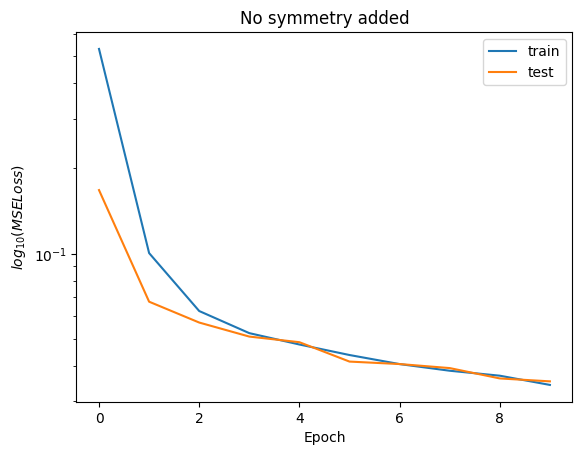

In [55]:
def plot_loss(loss_dict, name):
    plt.plot(loss_dict["train"], label="train")
    plt.plot(loss_dict["test"], label="test")
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("$log_{10}(MSE Loss)$")
    plt.title(f"{name}")
    plt.legend()
    plt.show()

plot_loss(loss_dict, "No symmetry added")


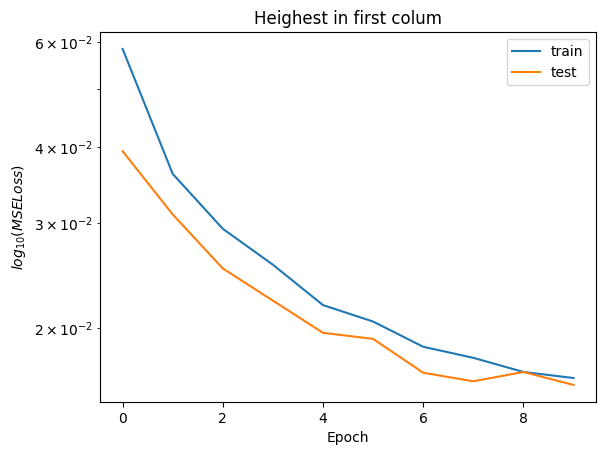

In [56]:
plot_loss(loss_dict_heighest_col, "Heighest in first colum")

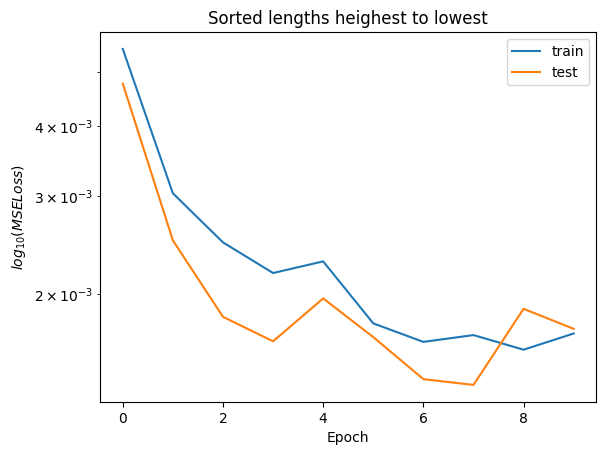

In [57]:
plot_loss(loss_dict_disamb, "Sorted lengths heighest to lowest")

In [58]:
import torch.nn as nn

# Very wide network
class WideNetwork(nn.Module):
    def __init__(self, input_dim=9):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 256, bias=False),
            nn.ReLU(),
            nn.Linear(256, 512, bias=False),
            nn.ReLU(),
            nn.Linear(512, 256, bias=False),
            nn.ReLU(),
            nn.Linear(256, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Very narrow network
class NarrowNetwork(nn.Module):
    def __init__(self, input_dim=9):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 8, bias=False),
            nn.ReLU(),
            nn.Linear(8, 4, bias=False),
            nn.ReLU(),
            nn.Linear(4, 2, bias=False),
            nn.ReLU(),
            nn.Linear(2, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Very deep network
class DeepNetwork(nn.Module):
    def __init__(self, input_dim=9):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 32, bias=False),
            nn.ReLU(),
            nn.Linear(32, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Shallow network (minimum depth for UAT)
class ShallowNetwork(nn.Module):
    def __init__(self, input_dim=9):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 1, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.linear_relu_stack(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [59]:
wide_model = WideNetwork()
wide_model, loss_dict_wide = train_model(
    data,
    model,
    nepochs=total_epochs,
    batch_size=batch_size,
    lr=lr,
    print_every=print_every,
    loss_fn=loss_fn,
)

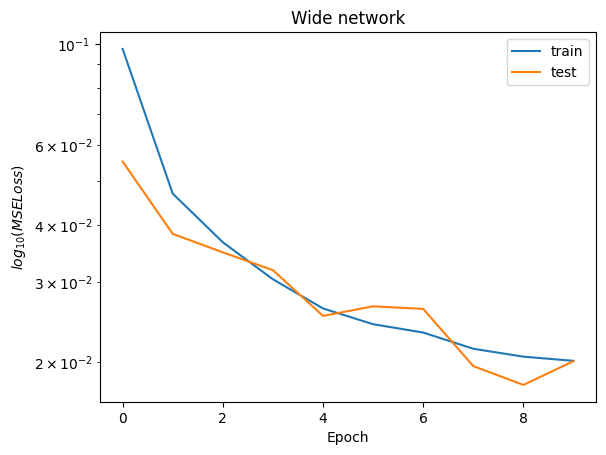

In [60]:
plot_loss(loss_dict_wide, "Wide network")

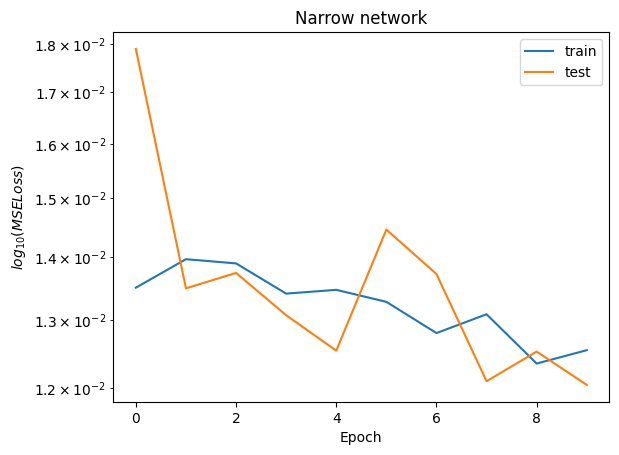

In [66]:
narrow_model = NarrowNetwork()
narrow_model, loss_dict_narrow = train_model(
    data,
    model,
    nepochs=total_epochs,
    batch_size=batch_size,
    lr=lr,
    print_every=print_every,
    loss_fn=loss_fn,
)

plot_loss(loss_dict_narrow, "Narrow network")

In [62]:
model_disamb.eval()
with torch.no_grad():
    for i in range(7):
        input_row = secret_test_disamb[i].unsqueeze(0)  # Add batch dimension
        label = i
        output = model(input_row)
        print(f"Row {i}: Prediction = {output}, Label = {label}")


Row 0: Prediction = tensor([[nan]]), Label = 0
Row 1: Prediction = tensor([[nan]]), Label = 1
Row 2: Prediction = tensor([[nan]]), Label = 2
Row 3: Prediction = tensor([[nan]]), Label = 3
Row 4: Prediction = tensor([[nan]]), Label = 4
Row 5: Prediction = tensor([[nan]]), Label = 5
Row 6: Prediction = tensor([[nan]]), Label = 6


In [63]:
model_disamb.eval()
with torch.no_grad():
    output_values = model_disamb(secret_test_disamb)

    
output_np = output_values.numpy()

# Save as a CSV
df_output = pd.DataFrame(output_np, columns=["prediction"])  # or more column names if needed
df_output.to_csv("predictions.csv", index=False)

In [64]:
output_values = pd.DataFrame()
for x in secret_test_disamb: 
    output_values.append() 
    
test_ids = test_set["id"].values

# submission_df = pd.DataFrame({'id': test_ids, 'prediction': preds_test.astype(int)})
# submission_df.to_csv("submission1.csv", index=False)
# print("Submission file saved as 'submission.csv'")

AttributeError: 'DataFrame' object has no attribute 'append'